In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.1 MB/s eta 0:00:00


In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 7.34.0

numpy       : 1.22.4
pandas      : 1.5.3
torch       : 2.0.1+cu118
transformers: 4.31.0



In [ ]:
import pandas as pd
import nltk
import re
import numpy as np
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Misc.
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [ ]:
def preprocess_comment(comment):
    # Tokenization
    tokens = nltk.word_tokenize(comment)

    # Remove URL/HTTP
    tokens = [re.sub(r'http\S+|www.\S+', '', token) for token in tokens]

    # Remove hashtags
    tokens = [token for token in tokens if not token.startswith('#')]

    # Remove usernames/user mentions
    tokens = [token for token in tokens if not token.startswith('@')]

    # Menghilangkan emotikon
    tokens = [re.sub(r'[^\w\s\d]', '', token) for token in tokens]

    # Remove symbols and numbers
    tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]

    # Lowercase
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    tokens = [token for token in tokens if token not in stopwords]

    # Join tokens back to a single string
    preprocessed_comment = ' '.join(tokens)

    return preprocessed_comment

In [ ]:
df = pd.read_csv("/content/facebook_playstore_test.csv", header=0, parse_dates=[0], index_col=0)

In [ ]:
df

,content,sentiment
361,It is a time pass app,0
73,Agar Free fire na hote to Facebook be nahi hon...,0
374,Won't update,2
155,Facebook can you give back my account because ...,0
104,"no more ""like"" notification on your status, pi...",2
...,...,...
347,But my I'd is not recover Facebook team ok hel...,1
86,Very good but some time freedom of speech prob...,2
75,Incredibly abusive and infested with vicious b...,2
438,To many fake profiles.,2


In [ ]:
# df['DateTime'] = pd.to_datetime(df['DateTime']).dt.date
df['content'] = df['content'].apply(preprocess_comment)

In [ ]:
df

,review,sentiment
507,since last update three days ago formatting ...,2
93,sure hacked twice lives ridiculous support r...,2
6,annoyed facebook boring actually pretty anno...,2
245,facebook hypocritical app possibly worst socia...,2
90,app full hate bigotry facebook busy targeting ...,2
...,...,...
69,like friends feed constantly covered sponsore...,2
472,transition originally facebook meta platform ...,2
304,app absolute garbage ipad videos watch alwa...,2
286,facebook gone dogs many ads marketplace junk...,2


In [ ]:
df_clean = df.dropna(how='all', subset=df.columns).replace('', np.nan).dropna()

In [ ]:
df_clean

,content,sentiment
361,time pass app,0
73,agar free fire na hote facebook nahi hone te,0
374,wo nt update,2
155,facebook give back account password right face...,0
104,like notification status picture video com...,2
...,...,...
347,recover facebook team ok help please,1
86,good time freedom speech problems,2
75,incredibly abusive infested vicious bullying ...,2
438,many fake profiles,2


In [ ]:
df_clean['sentiment'].unique()

array([0, 2, 1])

In [ ]:
df_clean['sentiment'] = df_clean['sentiment'].replace(0, 3)
df_clean['sentiment'] = df_clean['sentiment'].replace(2, 0)
df_clean['sentiment'] = df_clean['sentiment'].replace(1, 2)
df_clean['sentiment'] = df_clean['sentiment'].replace(3, 1)

In [ ]:
df_clean

,content,sentiment
361,time pass app,1
73,agar free fire na hote facebook nahi hone te,1
374,wo nt update,0
155,facebook give back account password right face...,1
104,like notification status picture video com...,0
...,...,...
347,recover facebook team ok help please,2
86,good time freedom speech problems,0
75,incredibly abusive infested vicious bullying ...,0
438,many fake profiles,0


In [ ]:
print(df_clean["sentiment"].unique())

[1 0 2]


In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
df_clean

,content,sentiment
361,time pass app,1
73,agar free fire na hote facebook nahi hone te,1
374,wo nt update,0
155,facebook give back account password right face...,1
104,like notification status picture video com...,0
...,...,...
347,recover facebook team ok help please,2
86,good time freedom speech problems,0
75,incredibly abusive infested vicious bullying ...,0
438,many fake profiles,0


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # bert-large-uncased

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
MAX_LEN = 200

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
def create_data_loader(df_clean, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df_clean['content'].to_numpy(),
    targets=df_clean['sentiment'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
BATCH_SIZE = 16

# train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
# val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_clean, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
model = SentimentClassifier(len(class_names))
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Copy of best_model_fullplatform_tirta.bin', map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint, strict=False)
model = model.to(device)

In [ ]:
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/Copy of best_model_fullplatform_tirta.bin'))
# model = model.to(device)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df)
)

test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

0.99

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
y_pred

tensor([1, 1, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2,
        1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2,
        0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 1, 0, 1, 2, 0, 2, 1, 2, 2, 1, 2, 0, 0, 1,
        1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0,
        0, 0, 0])

In [ ]:
y_test

tensor([1, 1, 0, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 1, 2, 2, 0, 2, 0, 0, 0, 0, 2,
        1, 2, 0, 0, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 2,
        0, 2, 2, 2, 2, 0, 2, 0, 0, 2, 1, 0, 1, 2, 0, 2, 1, 2, 2, 1, 2, 0, 0, 1,
        1, 2, 0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 2, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0,
        0, 0, 0])

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names, labels=[0, 1, 2]))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        43
     neutral       1.00      1.00      1.00        16
    positive       1.00      1.00      1.00        40

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



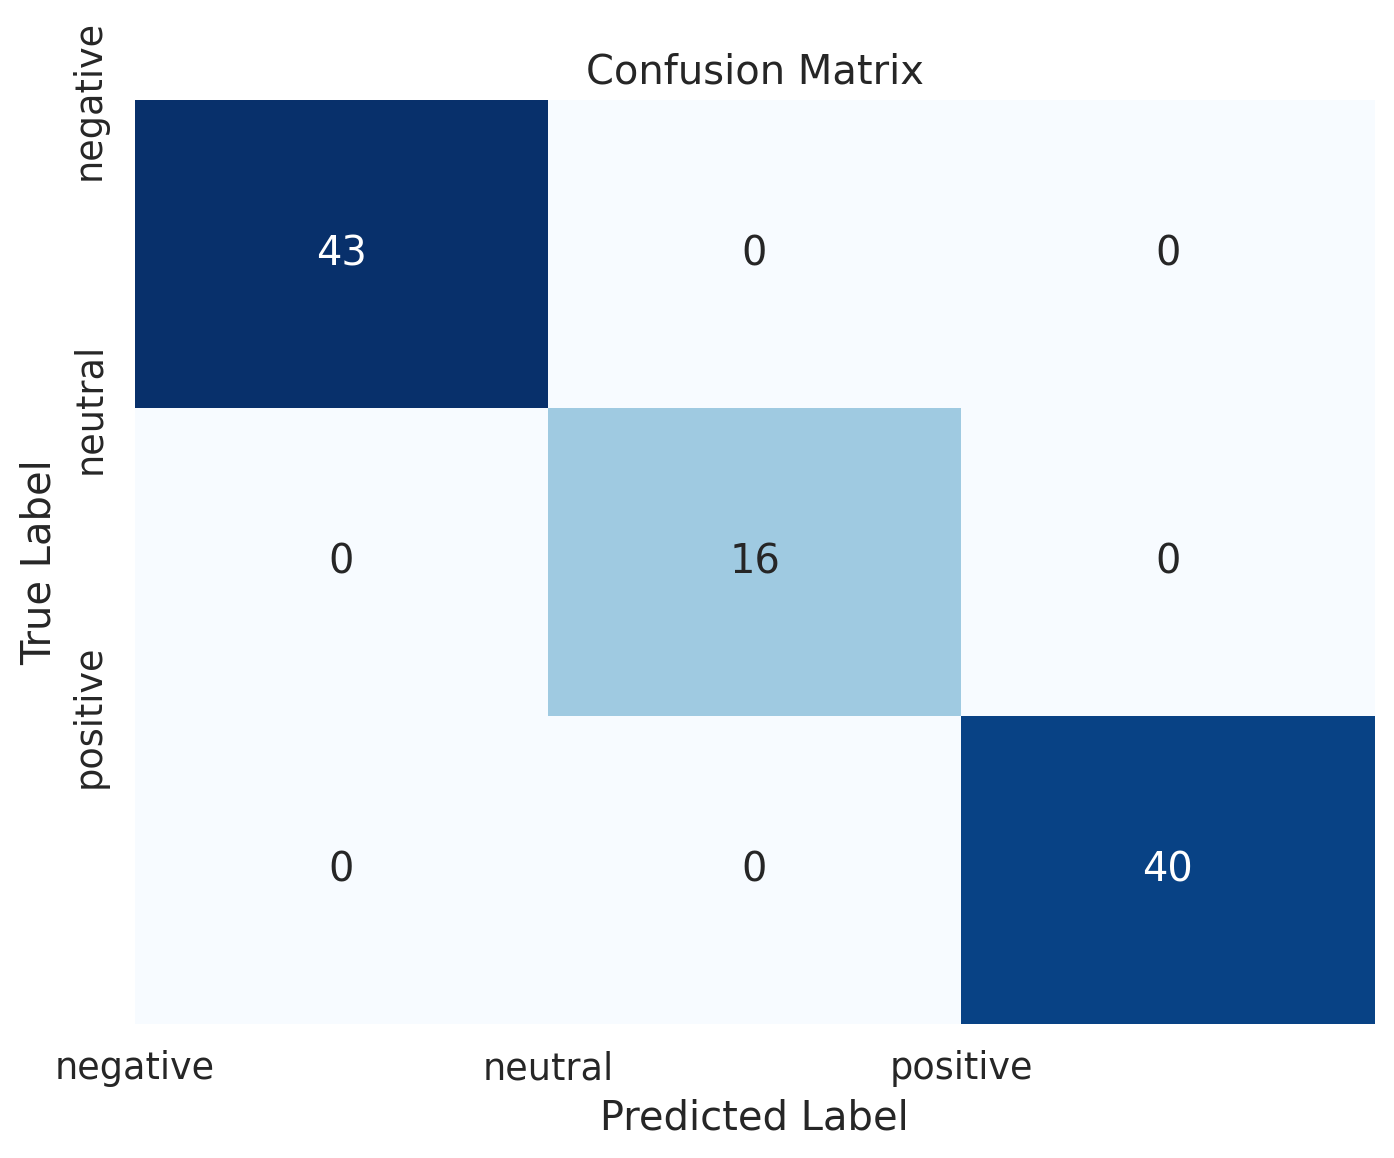

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xticks(ticks=range(len(class_names)), labels=class_names)
    plt.yticks(ticks=range(len(class_names)), labels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm, class_names)

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [ ]:
y_pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
y_test

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0])

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names, labels=[0, 1, 2]))

              precision    recall  f1-score   support

    negative       1.00      0.96      0.98       103
     neutral       0.00      0.00      0.00         0
    positive       0.50      1.00      0.67         2

    accuracy                           0.96       105
   macro avg       0.50      0.65      0.55       105
weighted avg       0.99      0.96      0.97       105



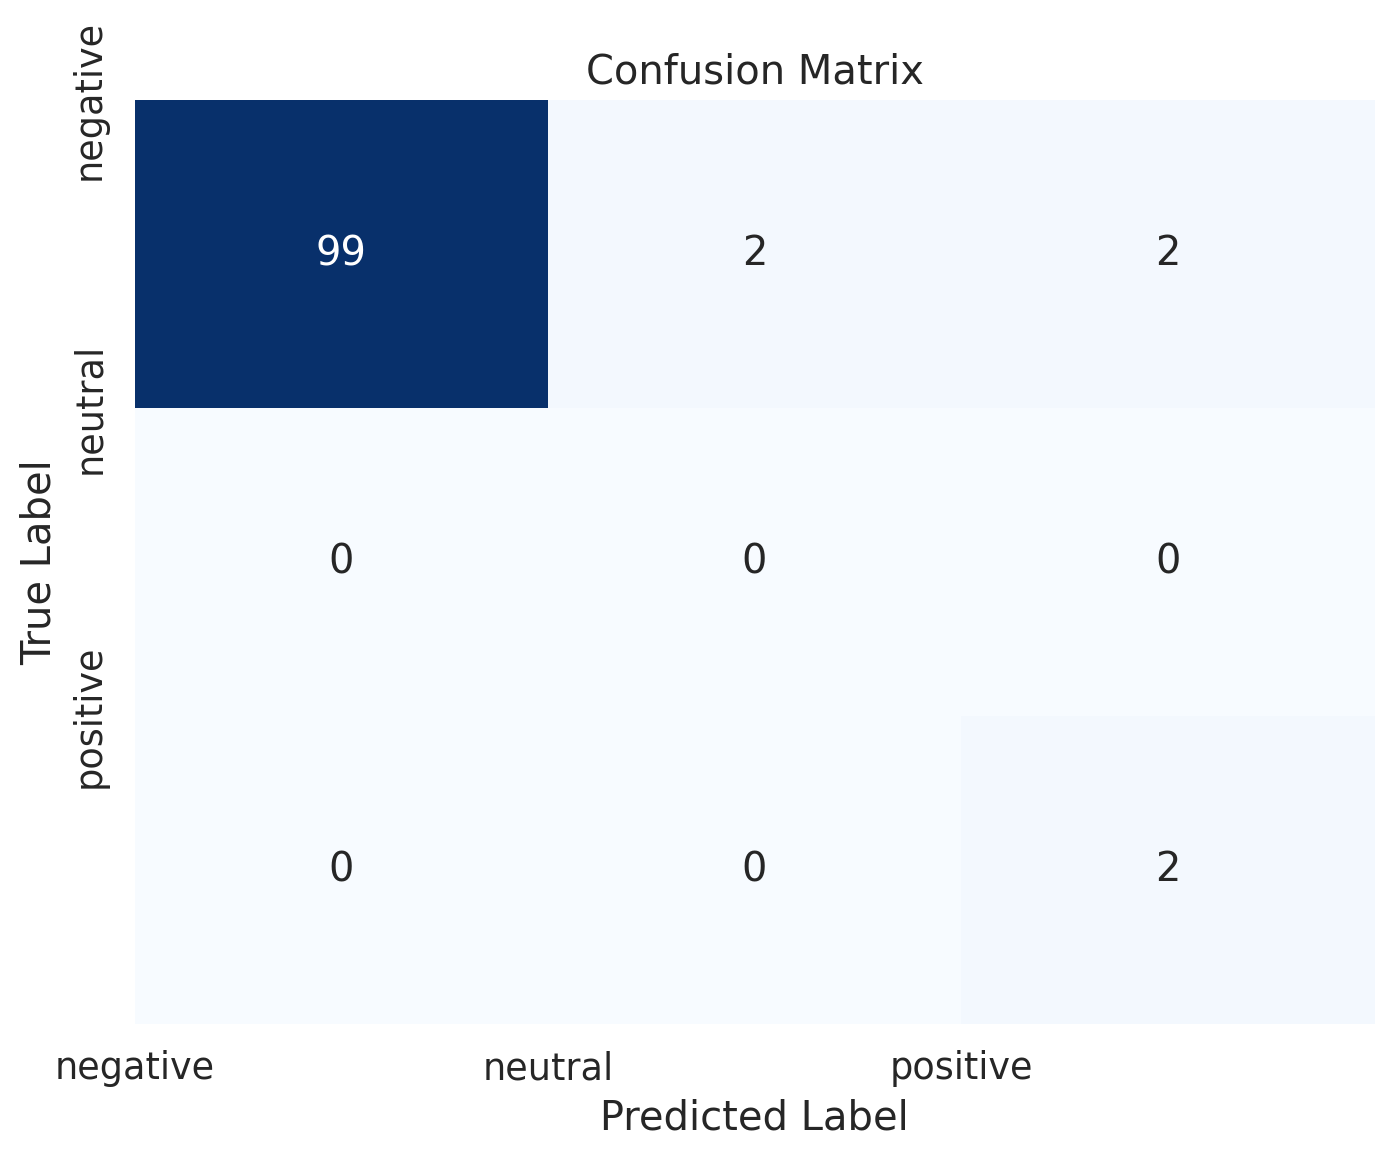

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xticks(ticks=range(len(class_names)), labels=class_names)
    plt.yticks(ticks=range(len(class_names)), labels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm, class_names)